# Import necessary libraries

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Data Loading

In [97]:
conn = pd.read_csv('../data/zeek_preprocessed/conn.csv')
dns = pd.read_csv('../data/zeek_preprocessed/dns.csv')
ssl = pd.read_csv('../data/zeek_preprocessed/ssl.csv')
files = pd.read_csv('../data/zeek_preprocessed/files.csv')
http = pd.read_csv('../data/zeek_preprocessed/http.csv')
x509 = pd.read_csv('../data/zeek_preprocessed/x509.csv')

conn['ts'] = pd.to_datetime(conn['ts'])
dns['ts'] = pd.to_datetime(dns['ts'])
ssl['ts'] = pd.to_datetime(ssl['ts'])
files['ts'] = pd.to_datetime(files['ts'])
http['ts'] = pd.to_datetime(http['ts'])
x509['ts'] = pd.to_datetime(x509['ts'])
x509['certificate.not_valid_before'] = pd.to_datetime(x509['certificate.not_valid_before'])
x509['certificate.not_valid_after'] = pd.to_datetime(x509['certificate.not_valid_after'])

# 2. Data exploration

#### Function for plotting histograms of categorical columns

In [98]:
def plot_categorical_histograms(df, exclude_columns=None, num_cols=3):
    """
    Plot histograms for categorical columns in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - exclude_columns (list of str): List of column names to exclude from plotting. Default is None.
    - num_cols (int): Number of columns in subplot grid. Default is 3.
    """
    if exclude_columns is None:
        exclude_columns = []

    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Filter out the columns to exclude
    columns_to_plot = [col for col in categorical_columns if col not in exclude_columns]

    # Calculate number of rows needed
    num_rows = -(-len(columns_to_plot) // num_cols)  # Ceiling division

    # Set up the plotting area with dynamic figsize
    figsize = (15, 5 * num_rows)  # Adjust height based on the number of rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    # Plot histograms for each categorical column
    for i, column in enumerate(columns_to_plot):
        df[column].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Count')

    # Hide any unused subplots
    for j in range(len(columns_to_plot), len(axes)):
        axes[j].axis('off')

    plt.show()

#### Function for plotting number of rows in each interval

In [99]:
def plot_connections_per_minute(df, time_column='ts', figsize=(12, 6)):
    """
    Resample data by minute and plot the number of rows in each interval.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - time_column (str): The name of the column to be used as the index for resampling (must be datetime).
    - figsize (tuple): Figure size (width, height). Default is (12, 6).
    """
    # Ensure the time_column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Create a deep copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Set the time_column as index
    df_copy.set_index(time_column, inplace=True)
    
    # Resample data by minute and count number of rows in each interval
    resampled_data = df_copy.resample('T').size()
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(resampled_data.index, resampled_data.values, marker='o', linestyle='-', color='b')
    plt.title('Number of Connections per Minute')
    plt.xlabel('Time')
    plt.ylabel('Number of Connections')
    plt.grid(True)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

### conn.log

In [100]:
conn

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0.010542,31.0,80.0,SF,Dd,1,59,1,108
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0.010908,33.0,87.0,SF,Dd,1,61,1,115
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0.010734,50.0,66.0,SF,Dd,1,78,1,94
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0.010405,37.0,91.0,SF,Dd,1,65,1,119
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0.009332,40.0,80.0,SF,Dd,1,68,1,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2020-09-02 15:27:20.320450068,CaStVq1Pbq8KOU84Ug,10.8.0.1,3,10.8.0.117,4,icmp,NaN,NaN,NaN,NaN,OTH,NaN,1,576,0,0
219,2020-09-02 15:27:20.300543070,CokYEW2q0cjgDIE5Gi,10.8.0.117,41360,104.244.42.66,443,tcp,ssl,300.203017,3612.0,1605.0,SF,ShADadTFfRR,46,7337,27,3017
220,2020-09-02 15:05:59.255357027,CYLKkn2Rnl8tV76MRi,10.8.0.117,47850,147.32.83.230,8000,tcp,http,1808.665546,1445.0,969.0,RSTR,ShADdTatr,148,9156,123,7874
221,2020-09-02 15:31:50.362519026,CXYOR91l3zR6DkwXc4,10.8.0.117,57736,74.125.71.188,5228,tcp,NaN,0.063148,28.0,26.0,OTH,DadA,2,132,2,130


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


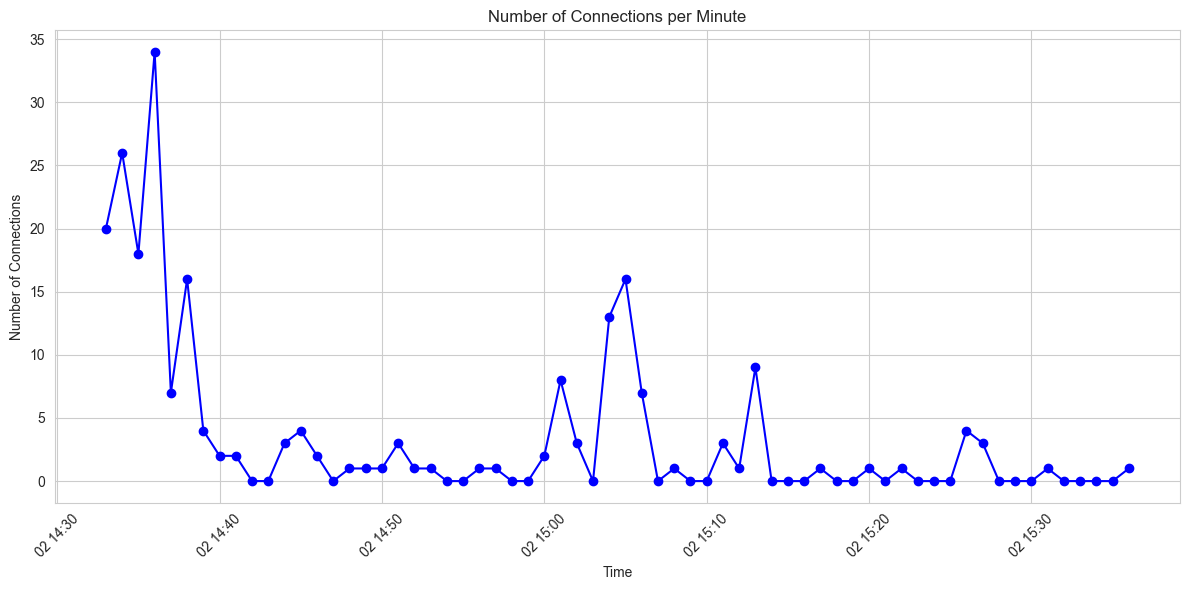

In [101]:
plot_connections_per_minute(conn)

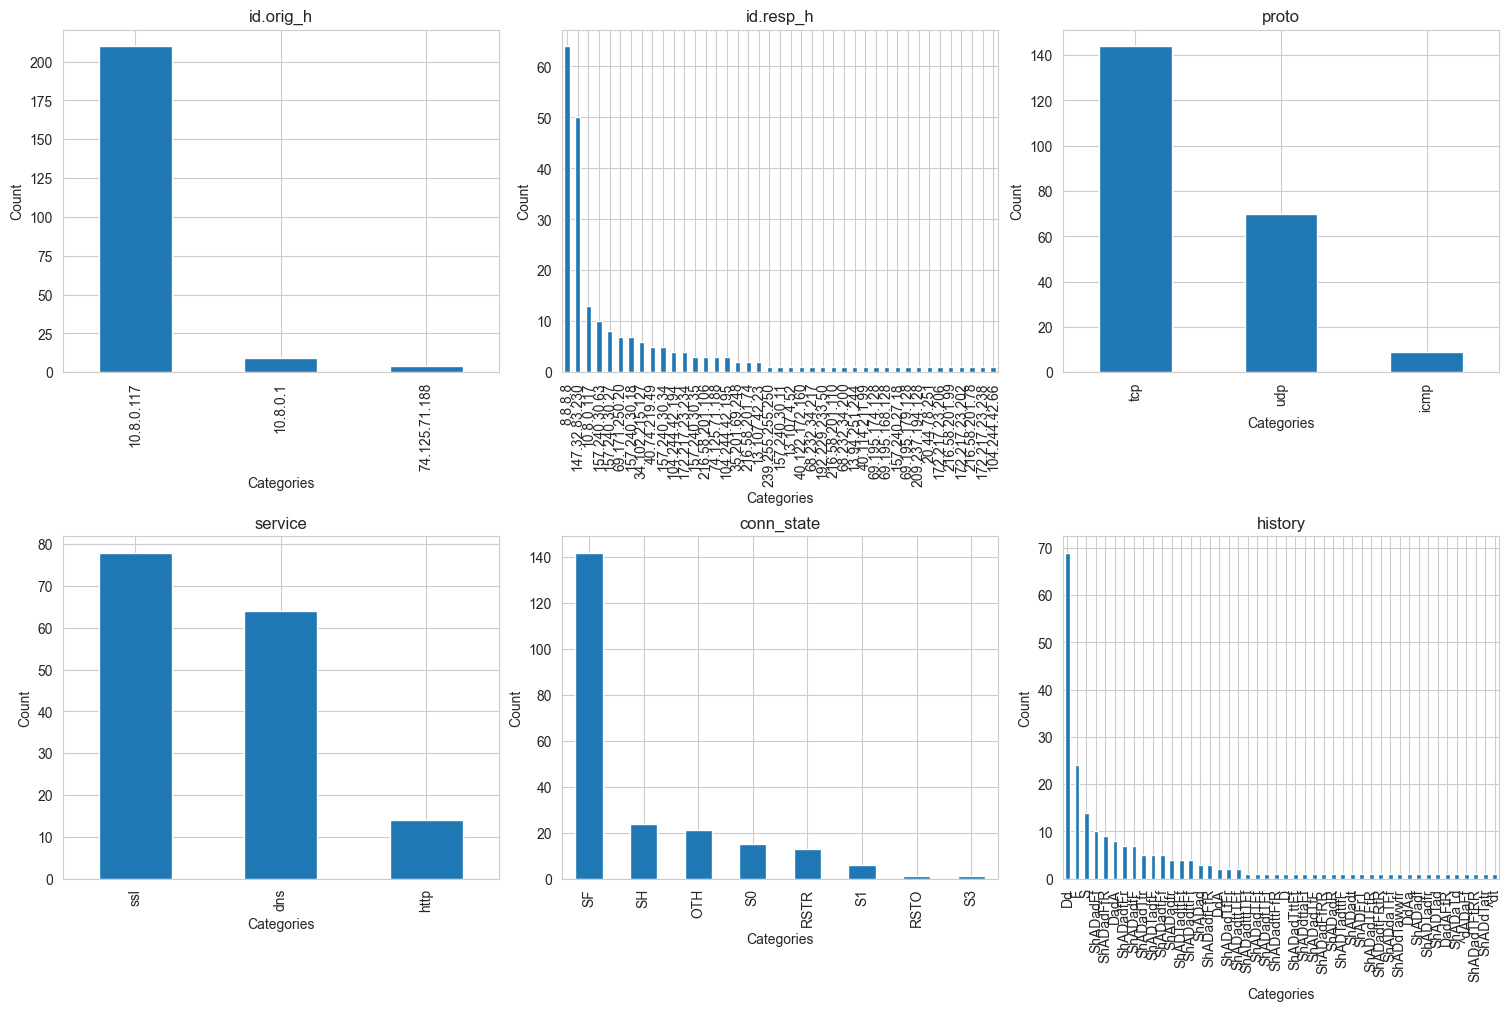

In [102]:
plot_categorical_histograms(conn, exclude_columns=['uid'])

### dns.log

In [103]:
dns

,ts,uid,id.orig_p,trans_id,rtt,query,answers,TTLs
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,1210,15630,0.010542,portal.fb.com,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000"
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,43814,35052,0.010908,i.instagram.com,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000"
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,51631,55600,0.010734,scontent-prg1-1.cdninstagram.com,157.240.30.63,59.000000
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,65449,39507,0.010405,graph.instagram.com,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000"
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,63247,41491,0.009332,edge-mqtt.facebook.com,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000"
...,...,...,...,...,...,...,...,...
59,2020-09-02 15:13:09.453067064,Cyw1E94W8FfeSPczJk,60718,64687,0.018982,android.googleapis.com,216.58.201.74,299.000000
60,2020-09-02 15:13:39.478319883,C0jMGu1frh9ei1Wmqc,60710,48649,0.009136,people-pa.googleapis.com,216.58.201.106,247.000000
61,2020-09-02 15:17:56.417140961,COs0MF2BvtxqwwWZBl,16281,23329,0.009862,people-pa.googleapis.com,216.58.201.106,248.000000
62,2020-09-02 15:26:19.691025019,CovR8F24TUZtn0RYGj,1075,36482,0.009263,global.glbtls.t.co,34.102.215.127,576.000000


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


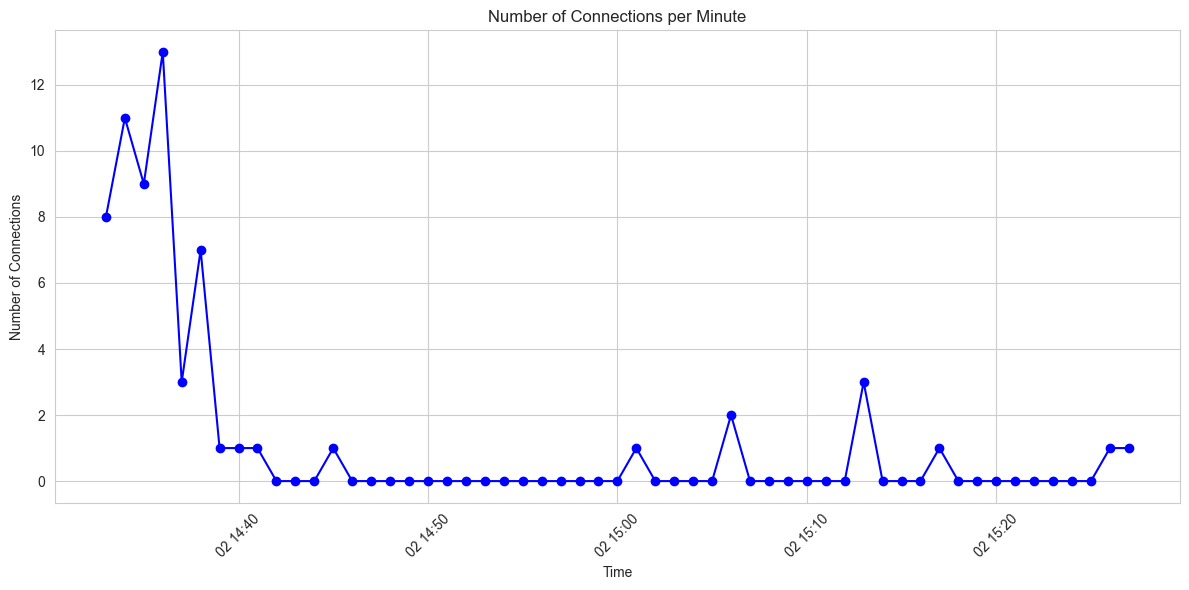

In [104]:
plot_connections_per_minute(dns)

### ssl.log

In [105]:
ssl

,ts,uid,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,next_protocol,established,cert_chain_fuids,subject,issuer
0,2020-09-02 14:33:48.338402033,CgnCcKyQn6Fuvtaaa,33952,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,i.instagram.com,T,NaN,T,NaN,NaN,NaN
1,2020-09-02 14:33:49.760056019,CyaZhP168fSnjEW4i,33954,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
2,2020-09-02 14:33:49.785082102,C1joeV1VXsHCLjiswg,33956,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
3,2020-09-02 14:33:49.816934109,CplZRBVCFLcGq4Dbl,33958,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
4,2020-09-02 14:33:49.826136112,C05gpYcCZjI5tZ4m5,33960,157.240.30.63,443,unknown-64282,TLS_AES_128_GCM_SHA256,x25519,scontent-prg1-1.cdninstagram.com,T,NaN,T,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020-09-02 15:13:56.091309071,CoqeK14slRRWT3jSG3,41734,216.58.201.106,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,people-pa.googleapis.com,F,NaN,T,NaN,NaN,NaN
74,2020-09-02 15:26:19.705396891,Cmz3aX3s2GpoaPURW,54090,34.102.215.127,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,global.glbtls.t.co,T,NaN,T,NaN,NaN,NaN
75,2020-09-02 15:26:19.895692110,Ci1SH62mLUPecPJx5d,38796,104.244.42.195,443,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,NaN,probe.twitter.com,T,http/1.1,T,NaN,NaN,NaN
76,2020-09-02 15:26:20.073468924,CupYkjJ1BXaXaZk94,54094,34.102.215.127,443,TLSv13,TLS_AES_128_GCM_SHA256,x25519,global.glbtls.t.co,T,NaN,T,NaN,NaN,NaN


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


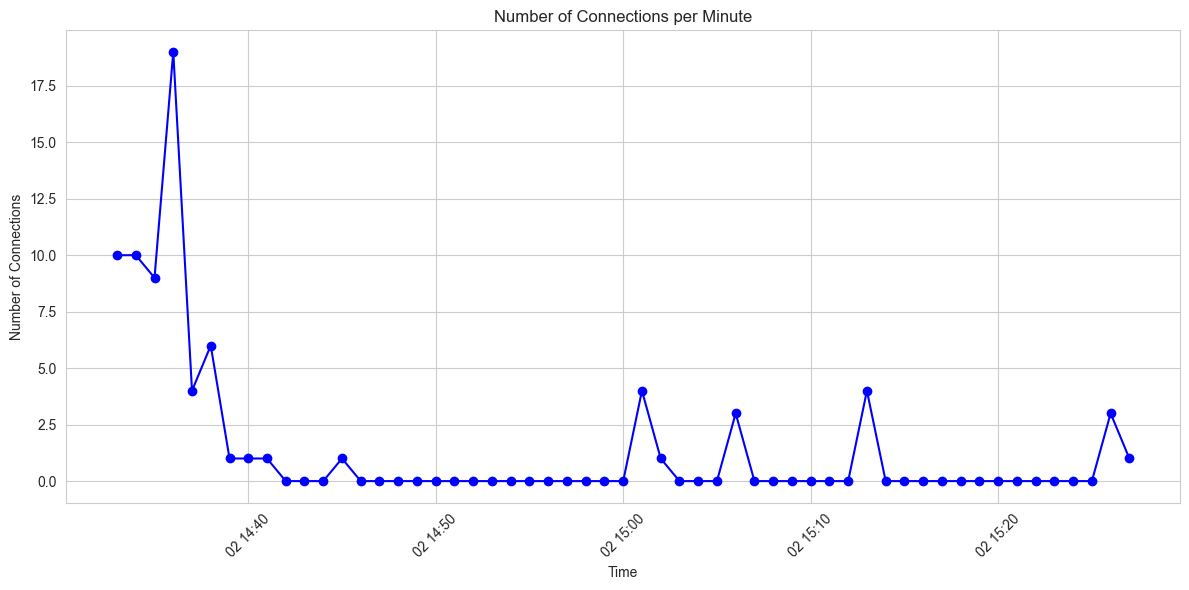

In [106]:
plot_connections_per_minute(ssl)

C:\Users\tigro\Desktop\Master_Study\2_semestr\SMU\ml-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


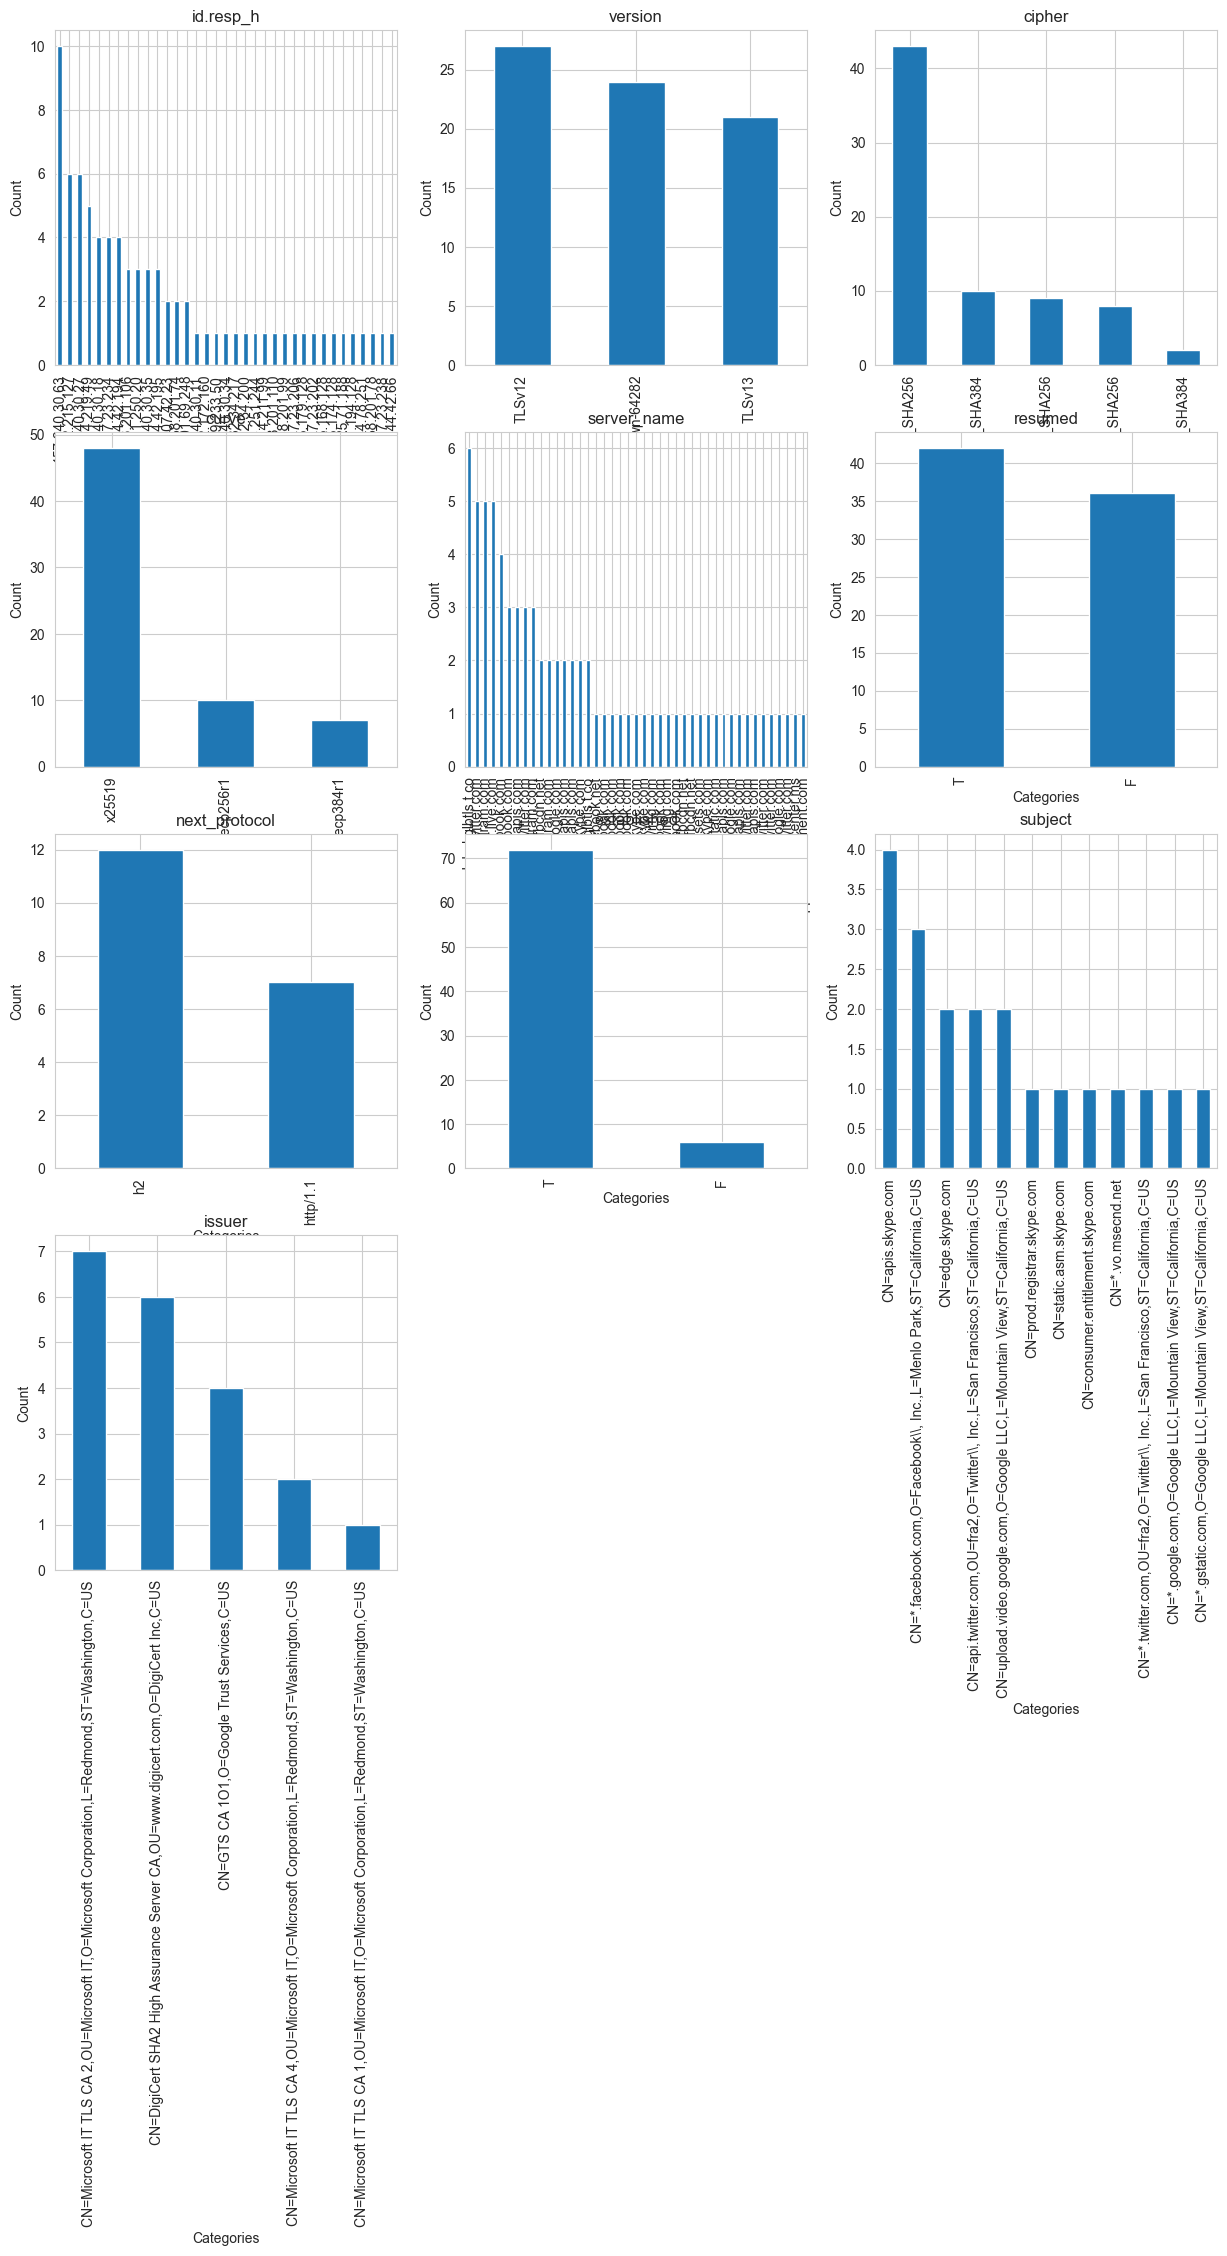

In [107]:
plot_categorical_histograms(ssl, exclude_columns=['uid', 'cert_chain_fuids'])

### http.log

In [108]:
http

,ts,uid,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,user_agent,request_body_len,response_body_len,status_code,status_msg,resp_fuids
0,2020-09-02 14:33:23.810384989,CBPoVA3CEo9RnTQNDj,58290,157.240.30.18,80,1,GET,portal.fb.com,/mobile/status.php,Facebook,0,0,204.0,No Content,NaN
1,2020-09-02 14:36:16.844291925,CriN9h1d6hCNTMi3P6,38680,13.107.4.52,80,1,GET,www.msftconnecttest.com,/connecttest.txt?n=1599057376803,okhttp/3.11.0,0,22,200.0,OK,FD0bxc2b2RRcwMJgR6
2,2020-09-02 14:39:00.430397987,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?model=unknown&EIO=3&id=3ad69a3e675...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,101,200.0,OK,Fn4Nyq2uspF7NKz5Sd
3,2020-09-02 14:39:03.634990931,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,2,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,5,200.0,OK,FFgr86DuOh95cXgD2
4,2020-09-02 14:39:03.647546053,CKwfPy2GoRYlUeD35i,47782,147.32.83.230,8000,3,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,4,200.0,OK,FBfRJY23EJDBjouIgi
5,2020-09-02 14:46:14.230858088,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?model=unknown&EIO=3&id=3ad69a3e675...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,101,200.0,OK,FjFdMuSXbZHaDExq6
6,2020-09-02 14:46:14.828830004,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,2,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,5,200.0,OK,Fw9Tz43sdEHYfJfWFj
7,2020-09-02 14:46:14.852785110,Cpl4DO1V4VtiWE0oBj,47800,147.32.83.230,8000,3,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,Dalvik/2.1.0 (Linux; U; Android 8.0.0; unknown...,0,4,200.0,OK,FXvc931jVqQOqy9Hwl
8,2020-09-02 14:39:03.638447046,C0Uxcf30mJ2Lq5wbX,47786,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,okhttp/3.5.0,0,0,101.0,Switching Protocols,NaN
9,2020-09-02 14:46:14.831793070,CNPVre20YbYQSMf7Ke,47802,147.32.83.230,8000,1,GET,147.32.83.230,/socket.io/?release=8.0.0&model=unknown&EIO=3&...,okhttp/3.5.0,0,0,101.0,Switching Protocols,NaN


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


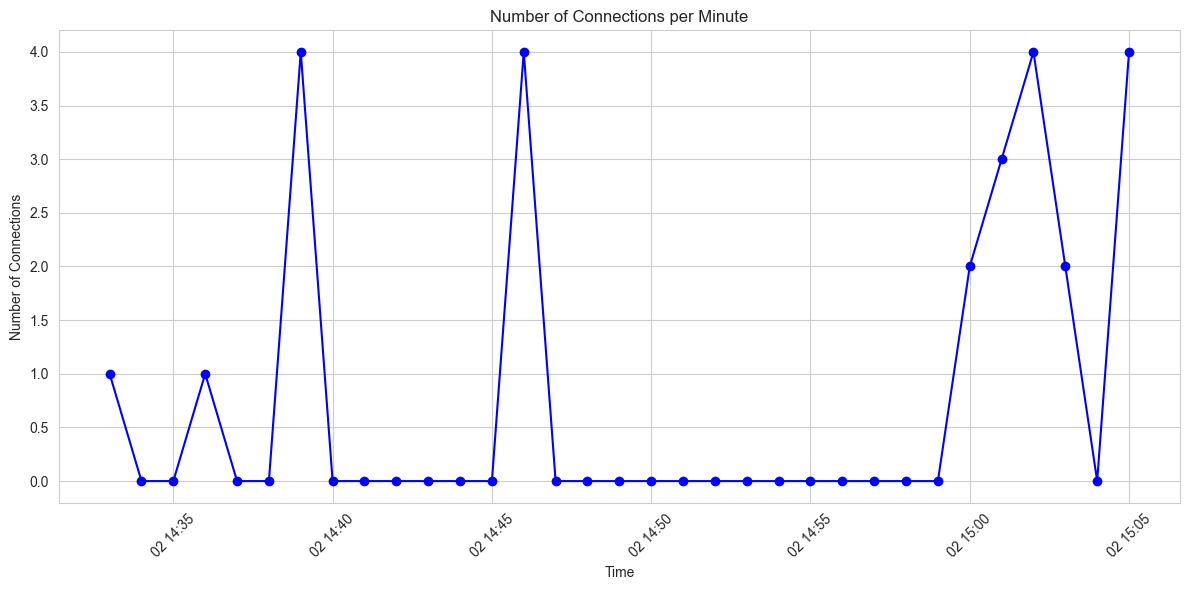

In [109]:
plot_connections_per_minute(http)

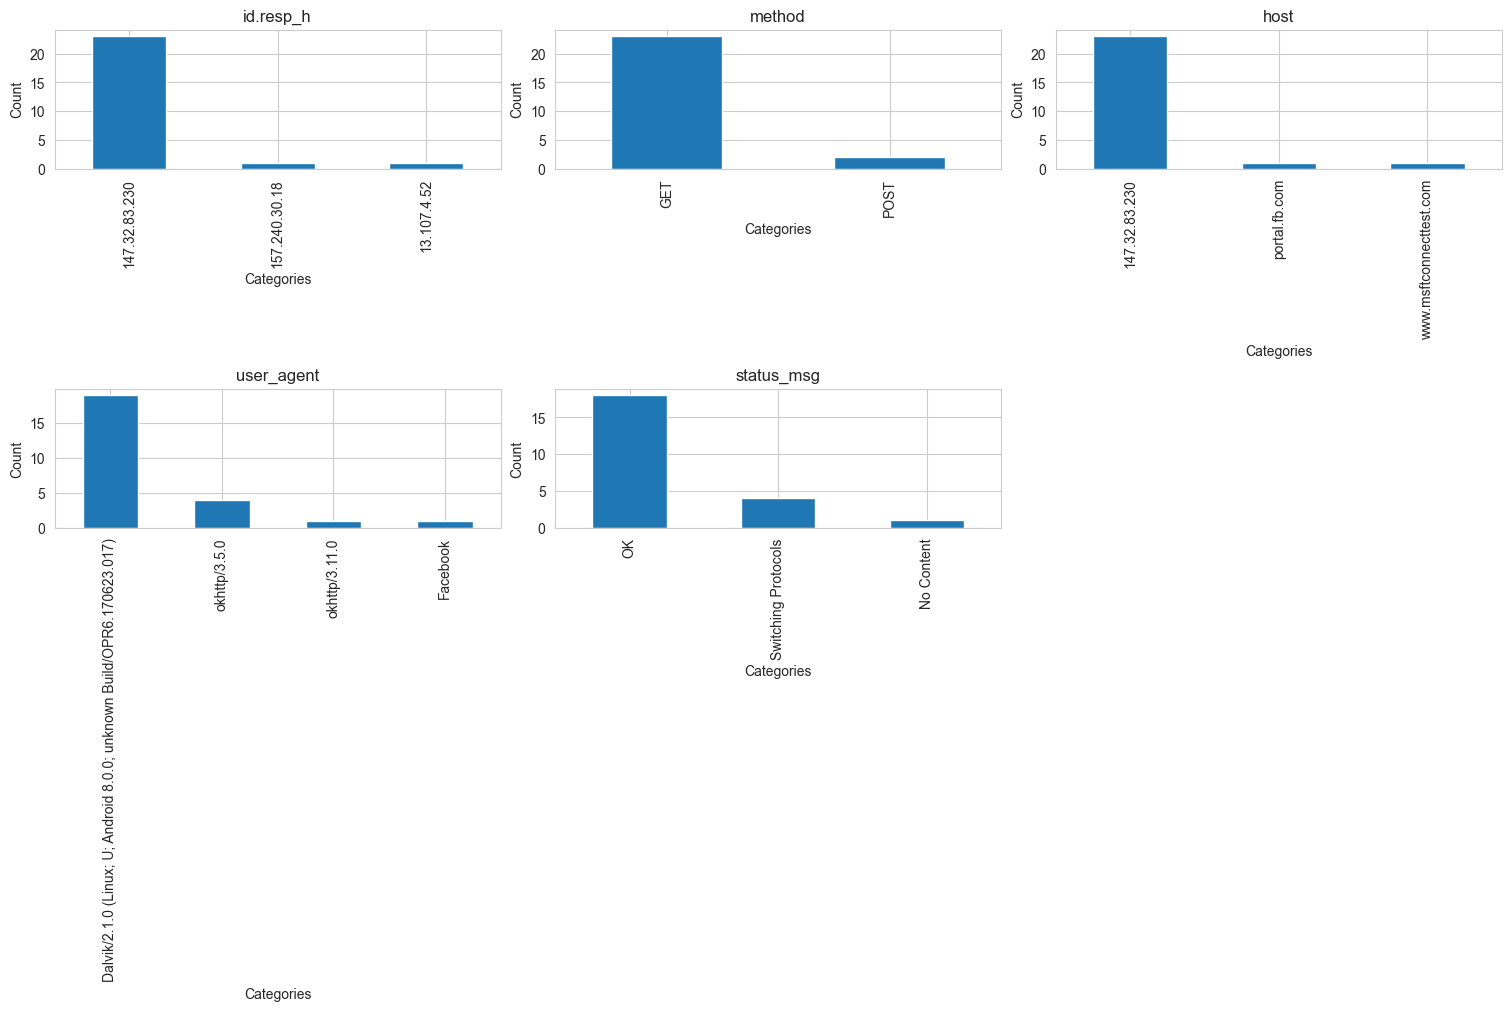

In [110]:
plot_categorical_histograms(http, exclude_columns=['uid', 'uri', 'resp_fuids'])

### files.log

In [111]:
files

,ts,fuid,tx_hosts,rx_hosts,conn_uids,source,analyzers,mime_type,is_orig,seen_bytes,total_bytes,md5,sha1,sha256
0,2020-09-02 14:33:51.558053017,F11cB51wbjfFUg2Hqk,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
1,2020-09-02 14:33:51.558053017,FmMSzw1GvTD6uTW1d9,157.240.30.11,10.8.0.117,CYaRbd1LgVHyMi0os7,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-ca-cert,F,1205,NaN,aaee5cf8b0d8596d2e0cbe67421cf7db,a031c46782e6e6c662c2c87c76da9aa62ccabd8e,19400be5b7a31fb733917700789d2f0a2471c0c9d506c0...
2,2020-09-02 14:34:15.589654922,FGkGth3S2vgqsSOeW9,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
3,2020-09-02 14:34:15.589654922,FpI5qi1NT6HlRITfm4,157.240.30.34,10.8.0.117,CE2v1V1PiJwfenwq22,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-ca-cert,F,1205,NaN,aaee5cf8b0d8596d2e0cbe67421cf7db,a031c46782e6e6c662c2c87c76da9aa62ccabd8e,19400be5b7a31fb733917700789d2f0a2471c0c9d506c0...
4,2020-09-02 14:34:59.079447031,FU4lIF474GDFf2hycj,69.171.250.20,10.8.0.117,CnCVN6i60NAbKmFxl,SSL,"SHA1,MD5,X509,SHA256",application/x-x509-user-cert,F,1579,NaN,e19002ec2bb5c0e7948cd6d78135affb,804630a5608b98ceecacfef4f4c848abe4519046,262c85b7e575e465100dc68eb7df059f0f705fd59e0998...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020-09-02 15:03:10.475212097,FcPgxI2DlGsDq4Iooe,147.32.83.230,10.8.0.117,CUhwFI2YjMkHyGju97,HTTP,"SHA1,MD5",NaN,F,4,4.0,c94b90fc9bdacb4b8efa79f71455723a,7b92da47b53515e492370f44792fbd37c1b948ce,NaN
66,2020-09-02 15:03:35.527549982,F0Jblz1wtu9YAE7sf8,10.8.0.117,147.32.83.230,CIrUMN3KNrQM1GRnU7,HTTP,"SHA1,MD5",NaN,T,4,4.0,929b5a8e73ca9450f2fa8b3e4b76b9e0,8ac2a8ffc06bf6dec00490114323704ebda01dd2,NaN
67,2020-09-02 15:05:59.249593973,FCuPUX3P4dyRQdf973,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",NaN,F,101,101.0,8db63e8db948313c60e5a2d703e86cf9,be4b038a23783e1ca913678e05804a7d458a0242,NaN
68,2020-09-02 15:05:59.261938094,FGApK81eAeQWObJDG6,147.32.83.230,10.8.0.117,C9x7S83q8VCbuVz4wl,HTTP,"SHA1,MD5",NaN,F,5,5.0,7af80a3ef50f8ab70677275473b1b1b8,bbddc27df3428bce641ace40dbd9afc0cd9ad583,NaN


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


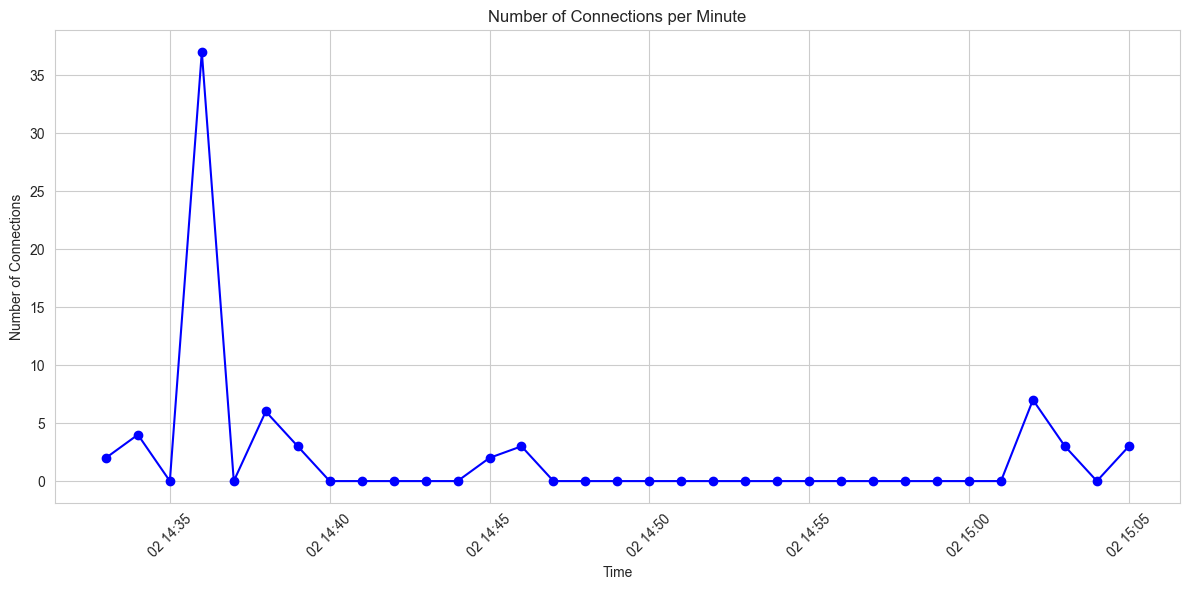

In [112]:
plot_connections_per_minute(files)

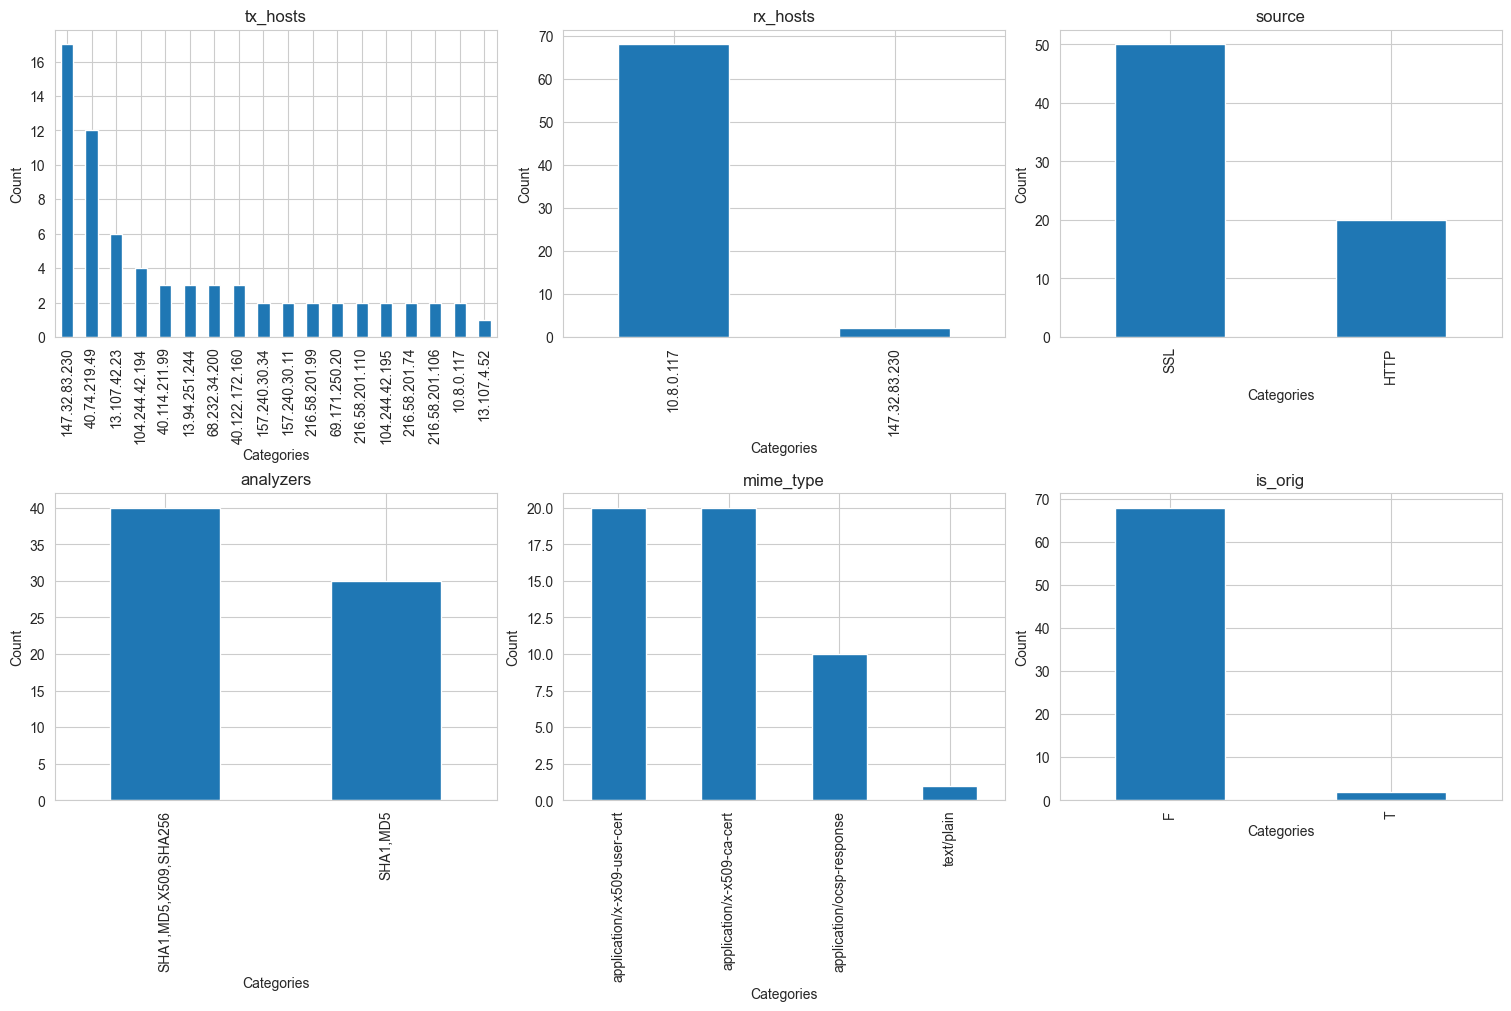

In [113]:
plot_categorical_histograms(files, exclude_columns=['fuid', 'conn_uids', 'resp_fuids', 'md5', 'sha1', 'sha256'])

### x509.log

In [114]:
x509

,ts,id,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.key_type,certificate.key_length,san.dns
0,2020-09-02 14:33:51.558053017,F11cB51wbjfFUg2Hqk,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
1,2020-09-02 14:34:15.589654922,FGkGth3S2vgqsSOeW9,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
2,2020-09-02 14:34:59.079447031,FU4lIF474GDFf2hycj,01C1AC2FB17829C72707395E7EF8CDB3,"CN=*.facebook.com,O=Facebook\\, Inc.,L=Menlo P...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-07-20 22:00:00,2020-10-12 10:00:00,id-ecPublicKey,ecdsa,256,"*.facebook.com,*.facebook.net,*.fbcdn.net,*.fb..."
3,2020-09-02 14:36:15.918709040,F5l1zD2OWAgyw4g1Y1,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=api.twitter.com,OU=fra2,O=Twitter\\, Inc.,L...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption,rsa,2048,api.twitter.com
4,2020-09-02 14:36:18.385674953,FrXiZ5fKhKL2s7Yv3,16000B42174A1FBE22833937FD0000000B4217,CN=edge.skype.com,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption,rsa,2048,"a.config.skype.com,a.config.skype.net,b.config..."
5,2020-09-02 14:36:18.470474958,F2IcbHptnvcAcsfob,16000B42174A1FBE22833937FD0000000B4217,CN=edge.skype.com,"CN=Microsoft IT TLS CA 4,OU=Microsoft IT,O=Mic...",2019-10-31 16:23:21,2021-10-31 16:23:21,rsaEncryption,rsa,2048,"a.config.skype.com,a.config.skype.net,b.config..."
6,2020-09-02 14:36:19.206903934,FQpYfl19rA6umwDOSi,0CFE7DBF9D968839FD4820BD6FC8A30E,"CN=api.twitter.com,OU=fra2,O=Twitter\\, Inc.,L...","CN=DigiCert SHA2 High Assurance Server CA,OU=w...",2020-03-04 23:00:00,2021-03-02 11:00:00,rsaEncryption,rsa,2048,api.twitter.com
7,2020-09-02 14:36:20.136914015,F4SBJJ15cqRXrv00sf,20000CB511346DFD3F696B063B0000000CB511,CN=prod.registrar.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2019-11-06 11:57:50,2021-11-06 11:57:50,rsaEncryption,rsa,2048,"prod.registrar.skype.com,*.prod.registrar.skyp..."
8,2020-09-02 14:36:20.370110035,FMfUcS3fSKYPdQOK2,200010761A732AD90380310E1600000010761A,CN=apis.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption,rsa,2048,"*.gateway.messenger.live.com,api.chat.skype.ne..."
9,2020-09-02 14:36:20.512145996,FuYDgm3is2A70nZECe,200010761A732AD90380310E1600000010761A,CN=apis.skype.com,"CN=Microsoft IT TLS CA 2,OU=Microsoft IT,O=Mic...",2020-01-23 10:06:51,2022-01-23 10:06:51,rsaEncryption,rsa,2048,"*.gateway.messenger.live.com,api.chat.skype.ne..."


C:\Users\tigro\AppData\Local\Temp\ipykernel_13268\824779064.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = df_copy.resample('T').size()


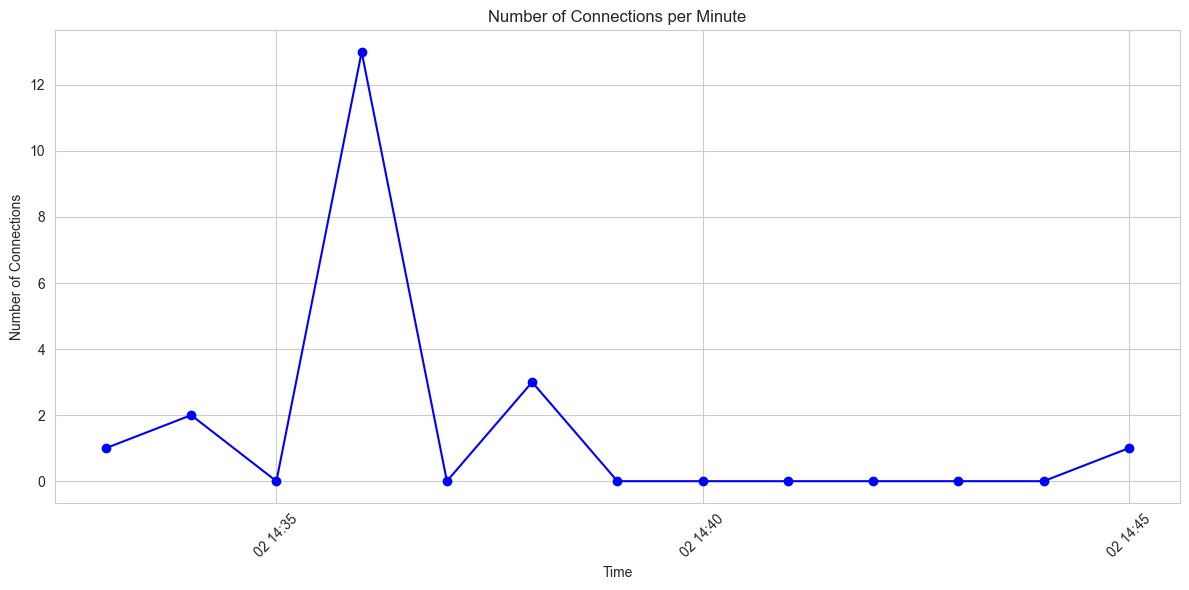

In [115]:
plot_connections_per_minute(x509)

C:\Users\tigro\Desktop\Master_Study\2_semestr\SMU\ml-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


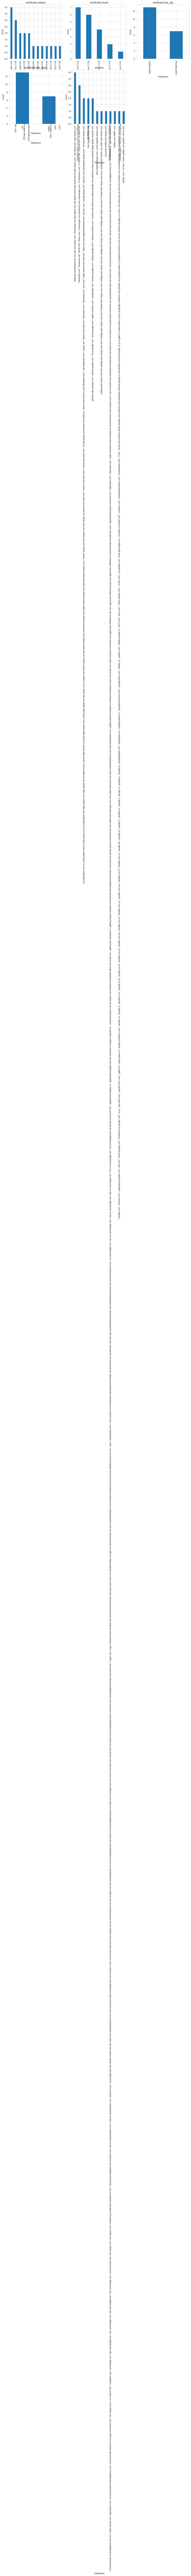

In [116]:
plot_categorical_histograms(x509, exclude_columns=['id', 'certificate.serial'])